In [1]:
! pip install geopandas scikit-learn haversine



[notice] A new release of pip is available: 23.2.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [6]:
"""
Objetivo: prever o valor médio das casas (MedHouseValue) usando:
 - variáveis socioeconômicas originais
 - features espaciais criadas a partir de lat/lon
 - validação com blocos geográficos simulados (GroupKFold)
"""
# ---------------- Configuração ----------------
import pandas as pd, geopandas as gpd, numpy as np
from sklearn.datasets import fetch_california_housing
from haversine import haversine_vector, Unit
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GroupKFold
from sklearn.metrics import mean_absolute_error

# 1. Carregar e preparar o dataset California Housing
cali = fetch_california_housing(as_frame=True)
df = cali.frame.copy()
df["longitude"] = cali.data["Longitude"]
df["latitude"]  = cali.data["Latitude"]

# 2. Transformar em GeoDataFrame
gdf = gpd.GeoDataFrame(
        df,
        geometry=gpd.points_from_xy(df.longitude, df.latitude),
        crs="EPSG:4326"
)

# 3. Engineering de features espaciais
la_center = (34.05, -118.24)
gdf["dist_LA_m"] = haversine_vector(          # distância em metros
    gdf[["latitude","longitude"]].values,
    [la_center],
    Unit.METERS,
    comb=True
).ravel()

gdf["pop_density_5k"] = gdf["Population"] / (np.pi * 5**2)

# 4. Criar blocos geográficos simples (3×3 grade)
lat_bins = pd.cut(gdf["latitude"],  bins=3, labels=False)
lon_bins = pd.cut(gdf["longitude"], bins=3, labels=False)
gdf["spatial_block"] = lat_bins * 3 + lon_bins       # 0-8

# 5. Preparar X, y e grupos
X = gdf[["MedInc","HouseAge","AveRooms","AveOccup",
         "dist_LA_m","pop_density_5k"]]
y = gdf["MedHouseVal"]
groups = gdf["spatial_block"]

# 6. GroupKFold evita que blocos vizinhos caiam em treino e teste
cv = GroupKFold(n_splits=5)
fold_mae, y_true_all, y_pred_all = [], [], []

for train_idx, test_idx in cv.split(X, y, groups):
    model = RandomForestRegressor(n_estimators=400, random_state=42)
    model.fit(X.iloc[train_idx], y.iloc[train_idx])
    preds = model.predict(X.iloc[test_idx])
    fold_mae.append(mean_absolute_error(y.iloc[test_idx], preds))
    y_true_all.extend(y.iloc[test_idx]); y_pred_all.extend(preds)

print(f"MAE médio com validação espacial: US$ {np.mean(fold_mae)*100_000:,.0f}")


MAE médio com validação espacial: US$ 64,470


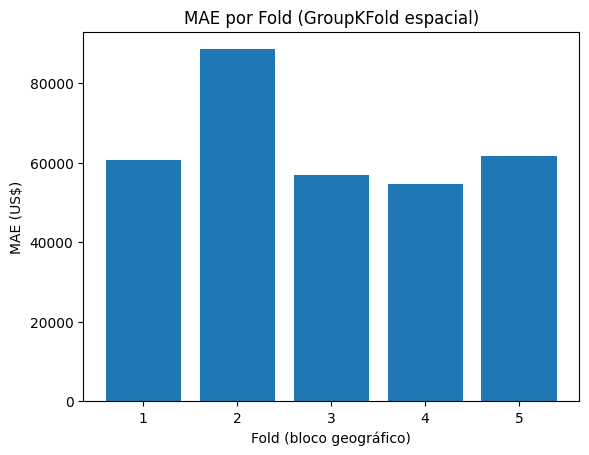

In [7]:
# 7. Visualização 1 – MAE por fold
import matplotlib.pyplot as plt

plt.figure()
plt.bar(range(1,6), [m*100_000 for m in fold_mae])
plt.xlabel("Fold (bloco geográfico)")
plt.ylabel("MAE (US$)")
plt.title("MAE por Fold (GroupKFold espacial)")
plt.show()



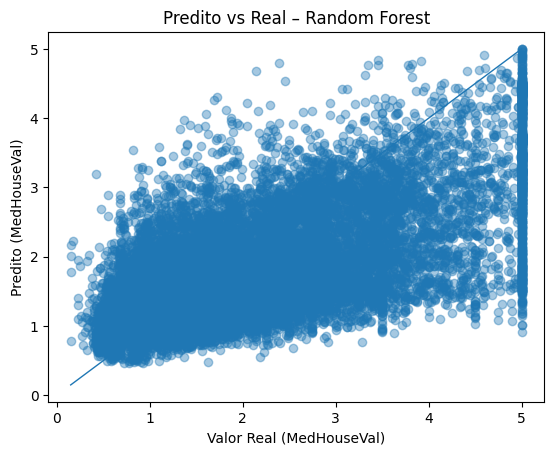

In [8]:
# 8. Visualização 2 – Predito vs Real
plt.figure()
plt.scatter(y_true_all, y_pred_all, alpha=0.4)
plt.plot([min(y_true_all), max(y_true_all)],
         [min(y_true_all), max(y_true_all)], linewidth=1)
plt.xlabel("Valor Real (MedHouseVal)")
plt.ylabel("Predito (MedHouseVal)")
plt.title("Predito vs Real – Random Forest")
plt.show()

In [3]:
from pysal.lib import weights
from pysal.explore import esda
import numpy
import pandas
import geopandas
import matplotlib.pyplot as plt
import seaborn
import contextily

c:\Users\PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\spaghetti\network.py:41: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and point pattern input as ``libpysal.cg`` geometries should prepare for this simply by converting to ``shapely`` geometries.
  warnings.warn(dep_msg, FutureWarning, stacklevel=1)
c:\Users\PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
